In [1]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

missing_counts = train_df.isnull().sum()
print("Columns with any missing values (train):")
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

# Drop columns that have very high missingness ( > 50% missing)
high_missing_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]

train_df = train_df.drop(columns=high_missing_cols)
test_df  = test_df.drop(columns=high_missing_cols)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape    : {test_df.shape}")


Columns with any missing values (train):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64
Training set shape: (1460, 76)
Test set shape    : (1459, 75)


In [3]:
# fill the remained missing values 

target = "SalePrice"                    
num_cols = [c for c in train_df.select_dtypes(include=["int64", "float64"]).columns if c != target]              
cat_cols = train_df.select_dtypes(include=["object"]).columns

for col in num_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    if col in test_df.columns:           # guard against KeyError
        test_df[col]  = test_df[col].fillna(median_val)

for col in cat_cols:
    mode_val = train_df[col].mode()[0] if not train_df[col].mode().empty else "None"
    train_df[col] = train_df[col].fillna(mode_val)
    if col in test_df.columns:
        test_df[col]  = test_df[col].fillna(mode_val)

print("Missing values remaining — train:", train_df.isnull().sum().sum(),
      " | test:",  test_df.isnull().sum().sum())


Missing values remaining — train: 0  | test: 0


In [5]:
# one‑hot‑encoding for all categorical features

target   = "SalePrice"
id_col   = "Id"          

combined = pd.concat(
    [train_df.drop(columns=[target]), test_df],
    axis=0,
    keys=["train", "test"]
)

combined_encoded = pd.get_dummies(combined, drop_first=True)

X_train = combined_encoded.xs("train")
X_test  = combined_encoded.xs("test")
y_train = train_df[target]

if id_col in X_train.columns:
    X_train = X_train.drop(columns=[id_col])
    X_test  = X_test.drop(columns=[id_col])

print("Encoded shapes →  X_train:", X_train.shape,
      "| X_test:", X_test.shape,
      "| y_train:", y_train.shape)


Encoded shapes →  X_train: (1460, 231) | X_test: (1459, 231) | y_train: (1460,)


In [7]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 1️⃣  Combine train (without target) & test, then one‑hot encode
# ------------------------------------------------------------------
target   = "SalePrice"
id_col   = "Id"

# Re‑use the cleaned DataFrames you already have
combined = pd.concat(
    [train_df.drop(columns=[target]), test_df],
    axis=0,
    keys=["train", "test"]
)

combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split back out
X_train_manual = combined_encoded.xs("train").astype(np.float64)
X_test_manual  = combined_encoded.xs("test" ).astype(np.float64)
y_train_manual = train_df[target].astype(np.float64).values.reshape(-1, 1)

# Optionally drop Id
if id_col in X_train_manual.columns:
    X_train_manual = X_train_manual.drop(columns=[id_col])
    X_test_manual  = X_test_manual.drop(columns=[id_col])

# ------------------------------------------------------------------
# 2️⃣  Add intercept & convert to NumPy
# ------------------------------------------------------------------
X = X_train_manual.to_numpy()
X = np.hstack([np.ones((X.shape[0], 1)), X])            # intercept
y = y_train_manual                                      # already 2‑D

# ------------------------------------------------------------------
# 3️⃣  80/20 manual train‑validation split
# ------------------------------------------------------------------
rng    = np.random.default_rng(42)
idx    = rng.permutation(X.shape[0])
split  = int(0.8 * X.shape[0])
tr_idx, val_idx = idx[:split], idx[split:]

X_tr, y_tr = X[tr_idx], y[tr_idx]
X_val, y_val = X[val_idx], y[val_idx]

# ------------------------------------------------------------------
# 4️⃣  Fit with the Normal Equation
# ------------------------------------------------------------------
theta = np.linalg.pinv(X_tr.T @ X_tr) @ (X_tr.T @ y_tr)

# ------------------------------------------------------------------
# 5️⃣  Evaluate
# ------------------------------------------------------------------
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot

y_val_pred = X_val @ theta
print(f"Validation RMSE: {rmse(y_val, y_val_pred):.2f}")
print(f"Validation R²  : {r2(y_val, y_val_pred):.4f}")

# ------------------------------------------------------------------
# 6️⃣  Retrain on full data
# ------------------------------------------------------------------
theta_full = np.linalg.pinv(X.T @ X) @ (X.T @ y)

# ------------------------------------------------------------------
# 7️⃣  Predict on test & save
# ------------------------------------------------------------------
X_test_np = X_test_manual.to_numpy()
X_test_b  = np.hstack([np.ones((X_test_np.shape[0], 1)), X_test_np])
test_pred = X_test_b @ theta_full

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_pred.ravel()
})
submission.to_csv("submission_manual.csv", index=False)
print("✅ Saved submission_manual.csv")


Validation RMSE: 37655.82
Validation R²  : 0.8096
✅ Saved submission_manual.csv


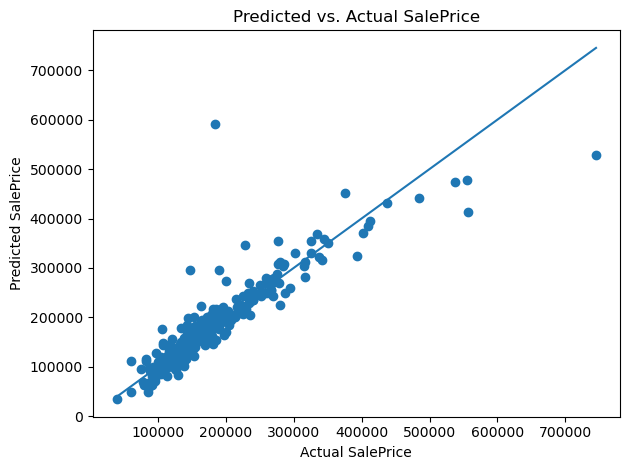

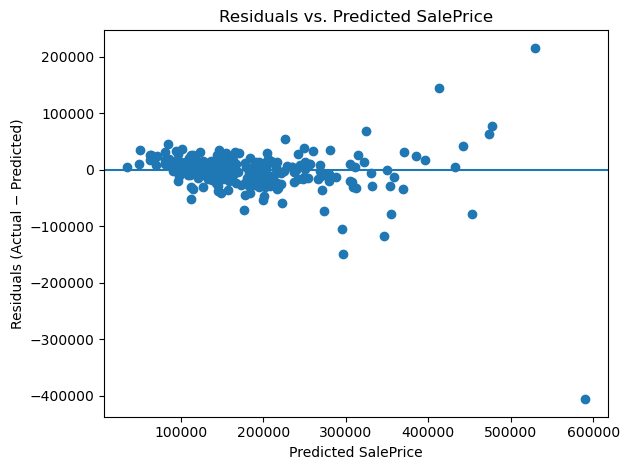

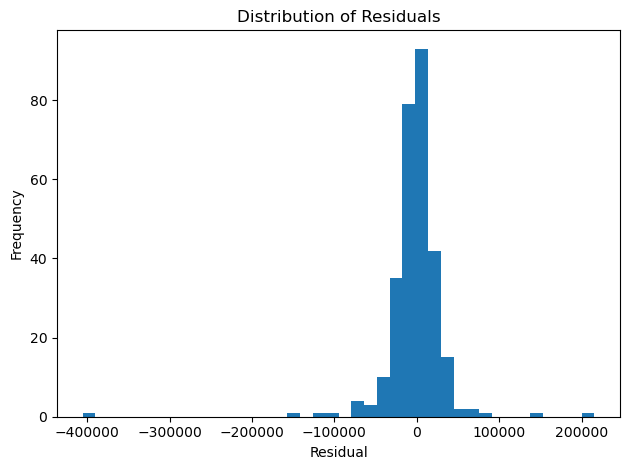

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# Make sure these two arrays exist from your manual fit:
#   y_val        – actual SalePrice values (shape: [n_val, 1] or [n_val])
#   y_val_pred   – predictions on validation split (same shape)
# If yours are named differently, just rename below.
# ------------------------------------------------------------------

# 1️⃣  Predicted vs. Actual
plt.figure()
plt.scatter(y_val, y_val_pred)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()])           # 45‑degree line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs. Actual SalePrice")
plt.tight_layout()
plt.show()

# 2️⃣  Residuals vs. Predicted
residuals = y_val - y_val_pred
plt.figure()
plt.scatter(y_val_pred, residuals)
plt.axhline(0)                                # zero‑error reference
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals (Actual − Predicted)")
plt.title("Residuals vs. Predicted SalePrice")
plt.tight_layout()
plt.show()

# 3️⃣  Histogram of Residuals
plt.figure()
plt.hist(residuals, bins=40)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.tight_layout()
plt.show()
